# Monte-Carlo simulation pay model

## TO DO:

- Database tables for model data
    * [X] Each pay option is listed in `pay_options` table
    * [X] Amounts associated with each option are in `pay_options_data`
    * [ ] The results (costs) of each option are stored in `model_results`


- Create bonus award option
    * [X] Same logic but for non-consolidated award


- Create dashboard with
    * Population analysis
    * Salary distribution
    * Stats on the pay bill and award pot
    * Effect of pay award

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sqlalchemy import create_engine

In [4]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
%config InlineBackend.figure_format = 'retina'

## Database connection

In [5]:
db_pass = os.getenv('PASSWORD')

In [6]:
# Server
if db_pass:
    engine = create_engine("postgresql://tm470_owner:{}@172.17.0.1/tm470".format(db_pass))
    conn = engine.connect()
else:
    # Local environment
    engine = create_engine("postgresql://Joachim:@localhost/tm470")
    conn = engine.connect()

### Load reference tables

#### Pay periods

In [7]:
pay_periods_df = pd.read_sql_table('pay_periods', conn)
pay_periods_df

,id,period_name,start_date,end_date,cutoff_date
0,1,2016/17,2016-04-01,2017-03-31,2017-01-01
1,2,2017/18,2017-04-01,2018-03-31,2018-01-01


In [13]:
pay_options_df = pd.read_sql_table('pay_options_v', conn)
pay_options_df

,id,name,type,period_name,cutoff_date
0,1,Pay award 16/17 - £1k (consolidated),Consolidated,2016/17,2017-01-01
1,2,Pay award 16/17 - Bonuses,Non-consolidated,2016/17,2017-01-01


#### Pay ranges

In [14]:
pay_ranges_df = pd.read_sql_table('pay_ranges_v', conn, index_col='payband')
pay_ranges_df

,min,max,period_name
payband,,,
1,64000,117800,2016/17
2,87000,162500,2016/17
3,106000,208100,2016/17


#### Consolidated pay option data

In [13]:
options_query = '''
SELECT key,
       payband,
       value
  FROM pay_options_data
 WHERE pay_option_id = 1
'''

In [14]:
option_df = pd.read_sql(options_query, conn)

In [15]:
option_df = option_df.pivot(index='payband', columns='key', values='value')
option_df

key,breakpoint,pay_award_tier1,pay_award_tier2,special_award,special_cases
payband,,,,,
1,80000.0,1000.0,250.0,2000.0,10.0
2,110000.0,1000.0,250.0,2000.0,5.0
3,135000.0,1000.0,250.0,NaN,NaN


#### Non-consolidated (bonus) option data

In [16]:
bonus_query = '''
SELECT key,
       payband,
       value
  FROM pay_options_data
 WHERE pay_option_id = 2
'''

In [17]:
bonus_df = pd.read_sql(bonus_query, conn)
bonus_df = bonus_df.pivot(index='payband', columns='key', values='value')
bonus_df

key,bonus
payband,
1,10750.0
2,10750.0
3,10750.0


### Load model data

In [18]:
def load_data_from_file():
    return pd.read_csv('data/model_data.csv', parse_dates=['hire_date'], 
                       thousands=',', index_col='emp_id')

def load_data_from_db():
    return pd.read_sql_table('model_data', conn, index_col='emp_id')

In [19]:
model_data = load_data_from_db()
df = model_data.copy()
df['headcount'] = 1
df['fte_salary'] = df['salary'] * df['fte']
df[:5]

,payband,salary,fte,hire_date,headcount,fte_salary
emp_id,,,,,,
1,1,62000,1.0,1992-01-04,1,62000.0
2,1,63000,1.0,2007-10-29,1,63000.0
3,1,63000,1.0,2015-06-10,1,63000.0
4,1,63000,1.0,2015-10-26,1,63000.0
5,1,63066,1.0,2015-01-09,1,63066.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 1 to 166
Data columns (total 6 columns):
payband       166 non-null int64
salary        166 non-null int64
fte           166 non-null float64
hire_date     166 non-null datetime64[ns]
headcount     166 non-null int64
fte_salary    166 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 9.1 KB


In [21]:
conn.close()

## Overview analysis

In [22]:
payband_stats = df.groupby(['payband'])['salary','fte'].aggregate({'salary': [np.sum, np.min, np.max, np.median],
                                                                   'fte': [np.sum, 'count']})
payband_stats

salary                             fte      
             sum    amin    amax  median     sum count
payband                                               
1        9738634   62000   98453   73267  124.51   130
2        3133471   86000  155250  105607   27.14    29
3         939355  122000  143350  135833    7.00     7

In [23]:
paybill = 13811459 # for testing
print('Est Paybill: £{:,}'.format(paybill))

Est Paybill: £13,811,459


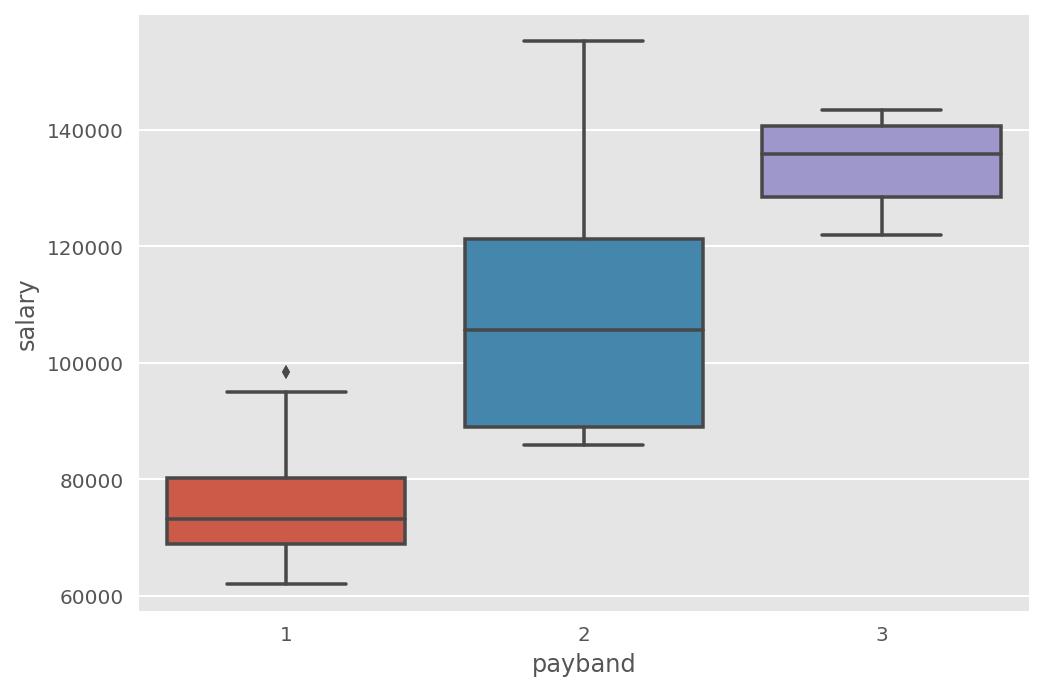

In [24]:
g = sns.boxplot(x='payband', y='salary', data=df)
#g.set_ylim(55000, 210000)

## Random number generation

In [25]:
# Generate random number according to the specified probability distribution
def _generate_random(n=1):
    r_n = npr.choice(3, n, p=[.25, .65, .10])
    return r_n + 1

In [29]:
# Assign random group and show distribution
n_recs = len(df)
df['random_group'] = _generate_random(n_recs)

group_totals = (df.groupby('random_group')['headcount'].agg([np.size])).rename(columns={'size': 'total'})
group_totals['percent'] = group_totals.total/sum(group_totals.total)
group_totals

,total,percent
random_group,,
1,42,0.253012
2,106,0.638554
3,18,0.108434


## Pay uplift

### New pay ranges

In [30]:
pay_ranges_df # from database

,min,max
payband,,
1,64000,117800
2,87000,162500
3,106000,208100


# Uplift to new min
Everyone is eligible

In [31]:
def _apply_pay_uplift(row):
    pb = str(row.payband)
    new_min = pay_ranges_df.loc[pb, 'min']
    if new_min > row.salary:
        return new_min - row.salary
    else:
        return 0

In [32]:
# Create new salary column 
temp_df = df.copy()
# Apply the pay uplift function column-wise
temp_df['uplift'] = temp_df.apply(_apply_pay_uplift, axis=1)
df = temp_df

### Calculate cost of uplift

In [33]:
uplift = df.uplift.sum()
'Cost of uplift: £{:,}'.format(uplift)

'Cost of uplift: £10,419'

In [34]:
'Cost of uplift: {:0.00}%'.format(uplift / paybill * 100)

'Cost of uplift: 0.08%'

### Analyse model population

In [37]:
df.groupby(['payband'])['salary','fte','headcount'].aggregate({
    'salary': ['min', 'max', np.mean, np.median],
    'fte': [np.sum],
    'headcount': ['count']
}).round(1).style.format('{:,}')

## Pay options

In [38]:
eligibility_date = pay_periods_df.get_value(0, 'cutoff_date')

In [39]:
option_df # from pay_options_data table

key,breakpoint,pay_award_tier1,pay_award_tier2,special_award,special_cases
payband,,,,,
1,80000.0,1000.0,250.0,2000.0,10.0
2,110000.0,1000.0,250.0,2000.0,5.0
3,135000.0,1000.0,250.0,NaN,NaN


In [40]:
def get_special_cases(df, option_df):
    '''
    Returns lists of lists of employee numbers of records randomly selected as
    special cases, based on the parameters specified in the pay model options.
    '''
    pb1_bpoint = option_df.loc[1, 'breakpoint']
    pb2_bpoint = option_df.loc[2, 'breakpoint']
    pb1_cases = option_df.loc[1, 'special_cases']
    pb2_cases = option_df.loc[2, 'special_cases']
    pb1_special = df[(df['payband'] == 1) & 
                     (df['salary'] < pb1_bpoint) &
                     (df['random_group'] < 3)].reset_index().sample(int(pb1_cases))['emp_id']
    pb2_special = df[(df['payband'] == 2) & 
                     (df['salary'] < pb2_bpoint) &
                     (df['random_group'] < 3)].reset_index().sample(int(pb2_cases))['emp_id']
    return pb1_special.tolist() + pb2_special.tolist()

In [41]:
special_cases = get_special_cases(df, option_df)
sorted(special_cases)

[2, 4, 14, 26, 31, 33, 35, 44, 65, 75, 133, 134, 135, 140, 142]

In [42]:
def _pay_award(row):
    pb = row.payband
    pay_award = 0
    # Apply the pay award for eligible employees
    if ((row.hire_date < pd.to_datetime(eligibility_date)) & (row.random_group < 3)):
        if row.salary < option_df.loc[pb, 'breakpoint']:
            pay_award = option_df.loc[pb, 'pay_award_tier1']
        else:
            pay_award = option_df.loc[pb, 'pay_award_tier2']
    
    # If the employee is a special case, apply additional award
    if row.emp_id in special_cases:
        if row.payband == 1:
            pay_award += option_df.loc[1, 'special_award']
        if row.payband == 2:
            pay_award += option_df.loc[2, 'special_award']
    
    return pay_award

In [43]:
award_df = df.reset_index()
award_df['pay_award'] = award_df.apply(_pay_award, axis=1)

In [45]:
# Fill N/A's with 0 to enable totals
# award_df = award_df.fillna(value=0)
award_df['new_salary'] = award_df['salary'] + award_df['pay_award'] + award_df['uplift']
award_df['pro_rata_cost'] = (award_df['pay_award'] + award_df['uplift']) * award_df['fte']

In [46]:
'Cost of award: £{:,}'.format(award_df['pro_rata_cost'].sum())

'Cost of award: £149,144.0'

In [47]:
'Cost of award: {:}%'.format(award_df['pro_rata_cost'].sum() / paybill * 100)

'Cost of award: 1.079856950666834%'

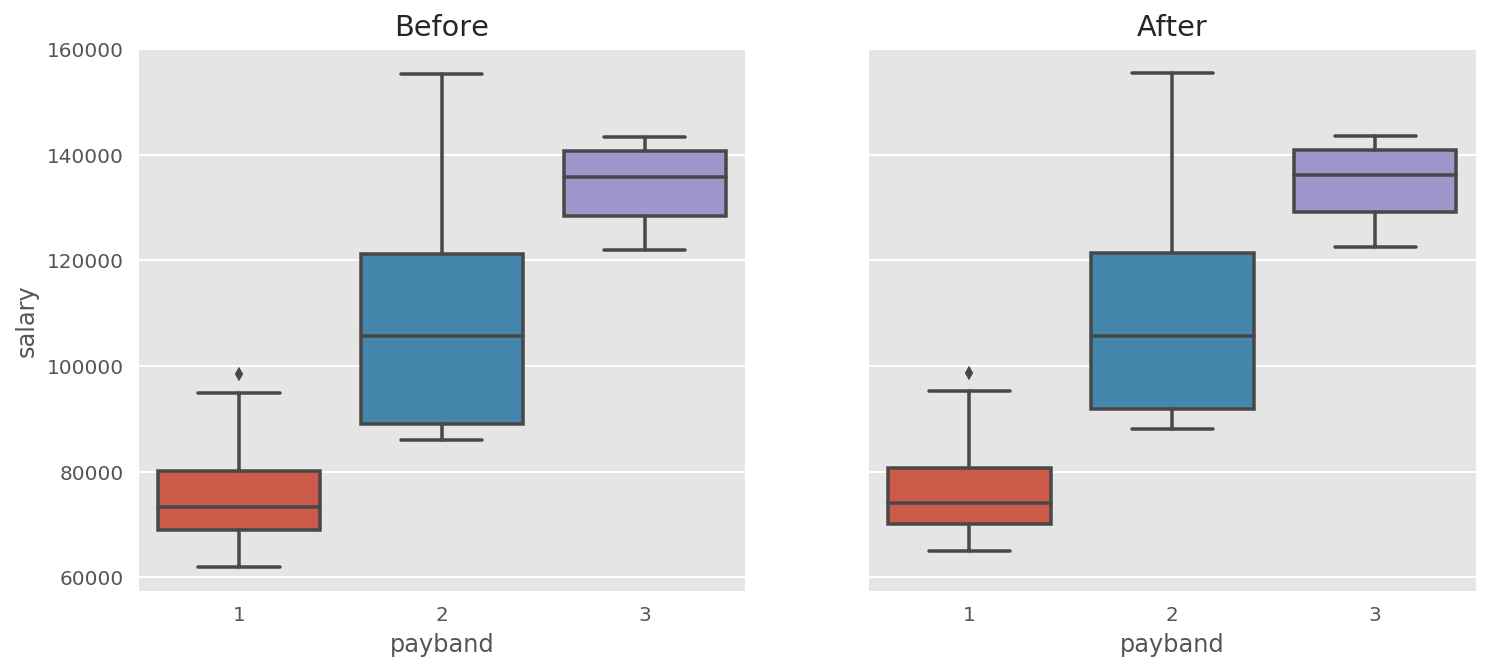

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(12,5))
sns.boxplot(x='payband', y='salary', data=df, ax=ax1)
ax1.set_title('Before')
sns.boxplot(x='payband', y='new_salary', data=award_df, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')

## Non-consolidated pay award

In [50]:
def _bonus_award(row):
    pb = row.payband
    # Apply the pay award for eligible employees
    if ((row.hire_date < pd.to_datetime(eligibility_date)) & (row.random_group == 1)):
        return bonus_df.loc[pb, 'bonus']
    else:
        return 0

In [51]:
award_df['bonus'] = award_df.apply(_bonus_award, axis=1)
award_df['pro_rata_bonus'] = award_df['bonus'] * award_df['fte']

In [ ]:
# Show a sample of current data
award_df[award_df['bonus']>0].sample(5)

In [53]:
bonus_total = award_df['pro_rata_bonus'].sum()
'Cost of bonus: £{:,}'.format(bonus_total)

'Cost of bonus: £423,227.5'

In [54]:
'Cost of bonus: {:}%'.format(award_df['pro_rata_bonus'].sum() / paybill * 100)

'Cost of bonus: 3.064321444968269%'

# Monte-Carlo Simulation

In [55]:
def run_simulation(df, paybill=None, N=100):
    df['headcount'] = 1
    df['fte_salary'] = df['salary'] * df['fte']
    
    n_recs = len(df)
    
    if paybill:
        paybill = paybill
    else:
        paybill = df['fte_salary'].sum()
    
    results = []
    
    for i in range(N):
        df['random_group'] = _generate_random(n_recs)
        
        model_distribution = df.groupby('random_group')['headcount'].agg([np.size]).rename(columns={'size':'total'})
        model_distribution['percent'] = model_distribution.total / model_distribution.total.sum()
        
        #############################
        # Apply uplift to new mins
        #############################
        temp_df = df.copy()
        temp_df['uplift'] = temp_df.apply(_apply_pay_uplift, axis=1)
        df = temp_df
        
        ############################
        # Apply pay awards
        ############################
        award_df = df.reset_index()
        df['pay_award'] = award_df.apply(_pay_award, axis=1)
        
        ############################
        # Apply bonus award
        ############################
        df['bonus'] = df.apply(_bonus_award, axis=1)
        df['pro_rata_bonus'] = df['bonus'] * df['fte']
        
        ############################
        # Analyse results 
        ############################
        # Fill N/A's with 0 to enable totals
        df = df.fillna(value=0)
        df['pro_rata_cost'] = (df['pay_award'] + df['uplift']) * df['fte']
        costs = df['pro_rata_cost'].sum()
        bonus_total = df['pro_rata_bonus'].sum()
        
        results.append({
            'group1': model_distribution.loc[1, 'percent'],
            'group2': model_distribution.loc[2, 'percent'],
            'group3': model_distribution.loc[3, 'percent'],
            'pay_costs': costs,
            'pay_percent': (costs / paybill) * 100,
            'bonus_costs': bonus_total,
            'bonus_percent': (bonus_total / paybill) * 100
        })
        
    return results

In [56]:
%%time
# source_df = load_data(n_recs=110)
source_df = model_data
output = run_simulation(source_df, option_df, paybill=13811459, N=100)

CPU times: user 7.5 s, sys: 36 ms, total: 7.54 s
Wall time: 7.57 s


In [57]:
results_df = pd.DataFrame(output)
results_df.mean().round(2)

bonus_costs      425837.60
bonus_percent         3.08
group1                0.25
group2                0.65
group3                0.10
pay_costs        148009.65
pay_percent           1.07
dtype: float64

In [58]:
results_df.describe().round(2)

,bonus_costs,bonus_percent,group1,group2,group3,pay_costs,pay_percent
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,425837.60,3.08,0.25,0.65,0.10,148009.65,1.07
std,60419.68,0.44,0.04,0.04,0.02,3054.48,0.02
min,290680.00,2.10,0.17,0.57,0.04,140351.50,1.02
25%,387725.62,2.81,0.23,0.63,0.08,145919.62,1.06
50%,423872.50,3.07,0.25,0.65,0.10,148171.50,1.07
75%,458138.12,3.32,0.27,0.68,0.11,150062.75,1.09
max,596840.00,4.32,0.34,0.74,0.14,155084.00,1.12


# Sample data for further analysis

### Generate random groups corresponding exactly with the guided distribution, i.e. 25%, 65% and 10%

In [61]:
def generate_best_distribution():
    def generate_random():
        df = model_data
        #df = source_df.drop('random_group', 1)
        n_recs = len(df)
        df['random_group'] = _generate_random(n_recs)

        group_totals = (df.groupby('random_group')['headcount'].agg([np.size])).rename(columns={'size': 'total'})
        group_totals['percent'] = group_totals.total/group_totals.total.sum()
        return group_totals, df
    
    group_totals, df = generate_random()
    
    while not ((group_totals.round(2).loc[1, 'percent'] > 0.245 and 
        group_totals.round(2).loc[1, 'percent'] <= 0.255) and
        (group_totals.round(2).loc[3, 'percent'] > 0.095 and 
            group_totals.round(2).loc[3, 'percent'] <= 0.105)):
        group_totals, df = generate_random()
    return group_totals, df

In [62]:
# Check distribution by random group
group_totals, df = generate_best_distribution()
group_totals

,total,percent
random_group,,
1,42,0.253012
2,108,0.650602
3,16,0.096386


In [65]:
# Check distribution within paybands
df.pivot_table(index='payband', columns='random_group', values='headcount', aggfunc=np.size, margins=True)

random_group,1,2,3,All
payband,,,,
1,37.0,80.0,13.0,130.0
2,5.0,21.0,3.0,29.0
3,NaN,7.0,NaN,7.0
All,42.0,108.0,16.0,166.0
